# **Thư viện**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error



# **Dữ liệu**

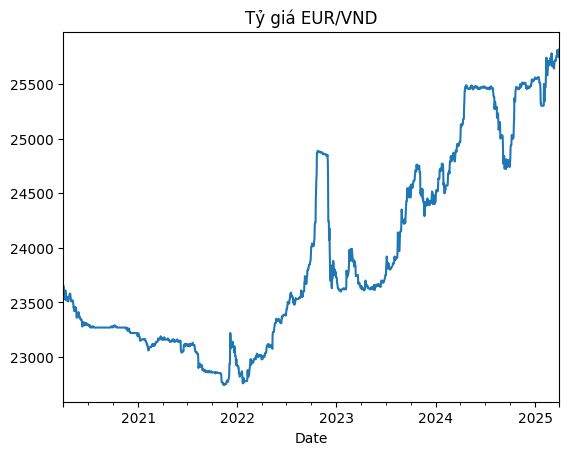

In [15]:
df = pd.read_csv(r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\data\processed\USD_VND_Exchange_Rate.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

y = df['Sell']
y.plot(title="Tỷ giá EUR/VND")
plt.show()

<Figure size 1400x1000 with 0 Axes>

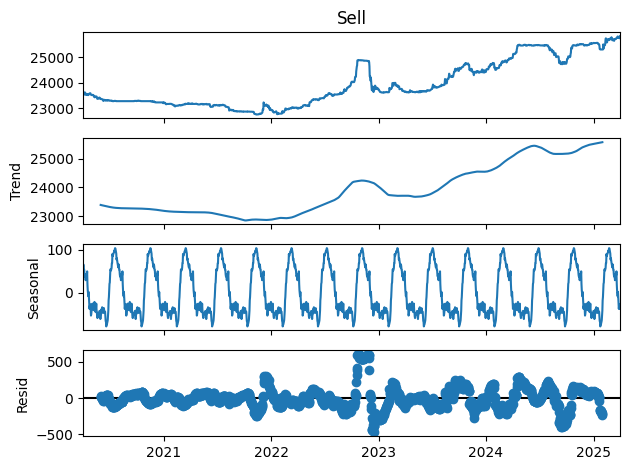

In [16]:
# Phân tích thành phần của chuỗi thời gian
decomposition = seasonal_decompose(df['Sell'], model='additive', period=120)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

# **Kiểm tra tính dừng (ADF Test)**

In [17]:
result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")


ADF Statistic: -0.23203883170978726
p-value: 0.9345933575042389
Chuỗi không dừng, cần lấy sai phân


## **Lấy sai phân**

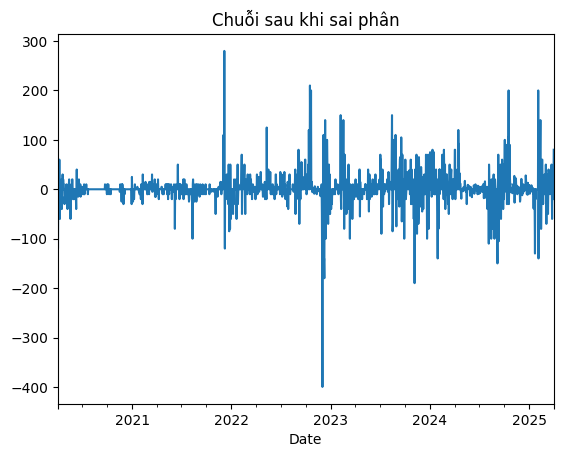

In [18]:
y_diff = y.diff().dropna()
y_diff.plot(title="Chuỗi sau khi sai phân")
plt.show()

In [19]:
result = adfuller(y_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")

ADF Statistic: -10.439102087602647
p-value: 1.5385894077431508e-18
Chuỗi dừng


=> d = 1

# **ACF và PACF để chọn p, q**

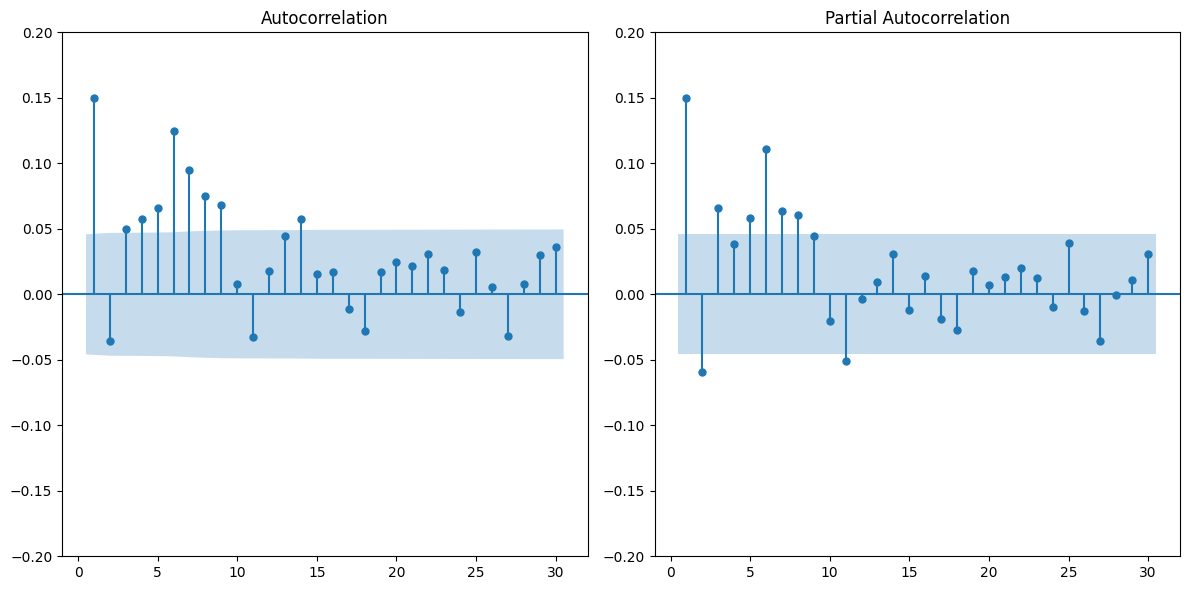

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

_ = plot_acf(y_diff, ax=ax1, lags=30, zero=False)
_ = plot_pacf(y_diff, ax=ax2, lags=30, zero=False)

ax1.set_ylim(-0.2, 0.2)
ax2.set_ylim(-0.2, 0.2)

plt.tight_layout()
plt.show()


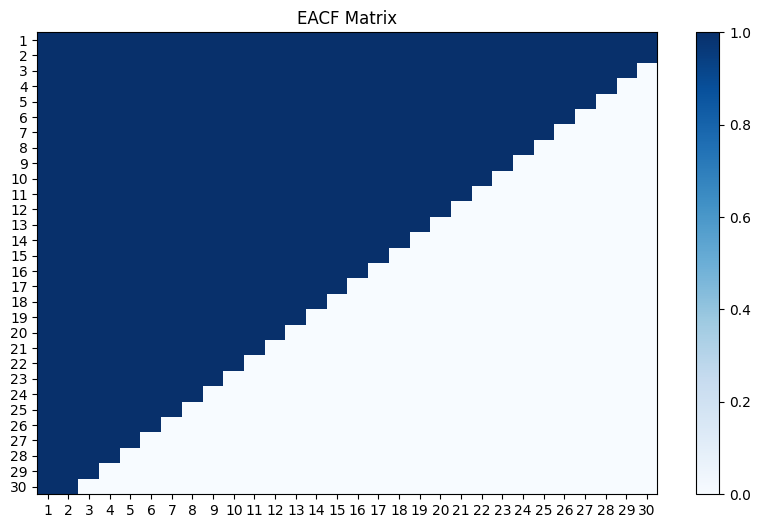

Bảng EACF:
x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
x x x x x x x x x x x x x x x x x x x x x x x x x x x x x o
x x x x x x x x x x x x x x x x x x x x x x x x x x x x o o
x x x x x x x x x x x x x x x x x x x x x x x x x x x o o o
x x x x x x x x x x x x x x x x x x x x x x x x x x o o o o
x x x x x x x x x x x x x x x x x x x x x x x x x o o o o o
x x x x x x x x x x x x x x x x x x x x x x x x o o o o o o
x x x x x x x x x x x x x x x x x x x x x x x o o o o o o o
x x x x x x x x x x x x x x x x x x x x x x o o o o o o o o
x x x x x x x x x x x x x x x x x x x x x o o o o o o o o o
x x x x x x x x x x x x x x x x x x x x o o o o o o o o o o
x x x x x x x x x x x x x x x x x x x o o o o o o o o o o o
x x x x x x x x x x x x x x x x x x o o o o o o o o o o o o
x x x x x x x x x x x x x x x x x o o o o o o o o o o o o o
x x x x x x x x x x x x x x x x o o o o o o o o o o o o o o
x x x x x x x x x x x x x x x

In [21]:
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

# Tính ACF và PACF
def compute_eacf(y, max_lag=30):
    n = len(y)
    max_lag = min(max_lag, n-1)  # Giới hạn max_lag để không vượt quá độ dài chuỗi
    acf_values = acf(y, nlags=max_lag, fft=True)
    pacf_values = pacf(y, nlags=max_lag)

    # Tạo ma trận EACF với các ký hiệu "o"
    eacf_matrix = np.full((max_lag, max_lag), 'o', dtype=str)

    # Xây dựng bảng EACF
    for p in range(max_lag):
        for q in range(max_lag):
            # Điều kiện "x" cho AR/MA
            if p + q < len(acf_values):  # Kiểm tra chỉ số hợp lệ
                # Kiểm tra điều kiện để thay thế "o" bằng "x"
                if acf_values[p + q] != 0 and pacf_values[p] != 0 and pacf_values[q] != 0:
                    eacf_matrix[p, q] = 'x'
    
    return eacf_matrix

# Tính bảng EACF
eacf_matrix = compute_eacf(df['Sell'])

# Hiển thị bảng EACF
plt.figure(figsize=(10, 6))
plt.imshow(eacf_matrix == 'x', cmap='Blues', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('EACF Matrix')
plt.xticks(range(len(eacf_matrix)), range(1, len(eacf_matrix) + 1))
plt.yticks(range(len(eacf_matrix)), range(1, len(eacf_matrix) + 1))
plt.show()

# In ra ma trận EACF
print("Bảng EACF:")
for row in eacf_matrix:
    print(" ".join(row))

# **ARIMA**

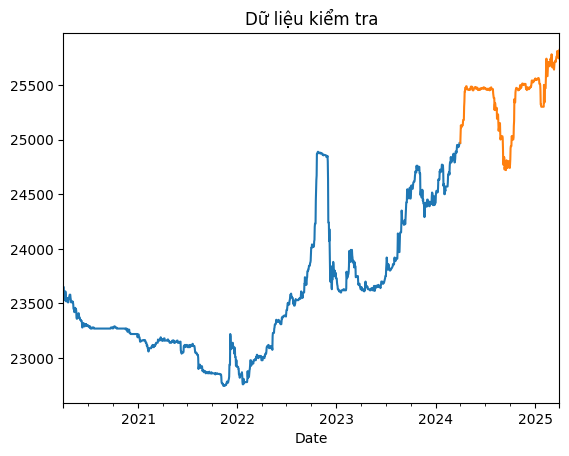

In [22]:
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

train.plot(title="Dữ liệu huấn luyện")
test.plot(title="Dữ liệu kiểm tra")
plt.show()

In [23]:
# Fit mô hình ARIMA(0, 1, 0) trên tập huấn luyện
model = ARIMA(train, order=(4, 1, 4))
result = model.fit()

print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                   Sell   No. Observations:                 1461
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -6996.840
Date:                Sat, 12 Apr 2025   AIC                          14011.680
Time:                        23:09:56   BIC                          14059.256
Sample:                    04-01-2020   HQIC                         14029.428
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6868      0.183      3.753      0.000       0.328       1.045
ar.L2          0.3954      0.265      1.491      0.136      -0.124       0.915
ar.L3         -0.0570      0.145     -0.393      0.6

# **Đánh giá mô hình**

MAE: 445.66019150700856
MSE: 234280.42606173077
RMSE: 484.0252328770999
MAPE: 1.7487303018646503%


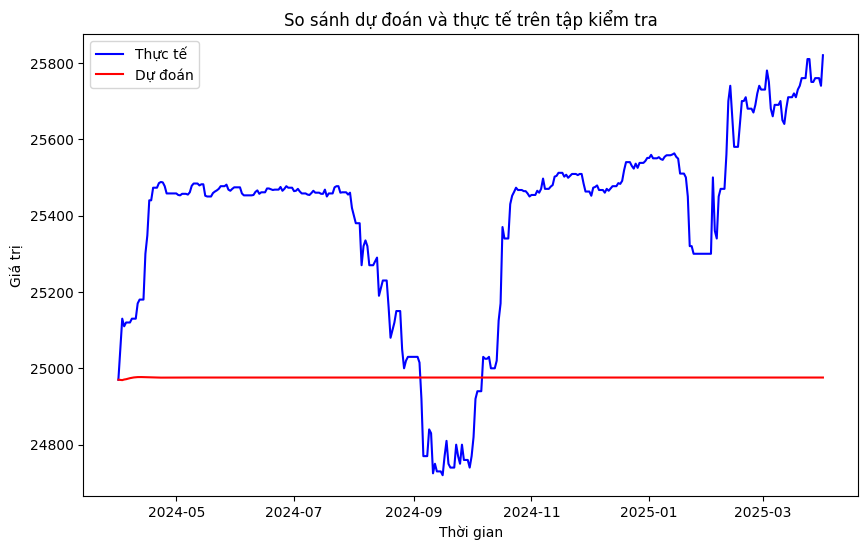

In [24]:
# Dự báo trên tập kiểm tra (test)
y_pred = result.forecast(steps=len(test))

# Đánh giá mô hình
MAE = mean_absolute_error(test, y_pred)
MSE = mean_squared_error(test, y_pred)
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((test - y_pred) / test)) * 100

print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"MAPE: {MAPE}%")

# Vẽ biểu đồ so sánh thực tế và dự báo
plt.figure(figsize=(10, 6))
plt.plot(test, label='Thực tế', color='blue')
plt.plot(y_pred, label='Dự đoán', color='red')
plt.title('So sánh dự đoán và thực tế trên tập kiểm tra')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.show()


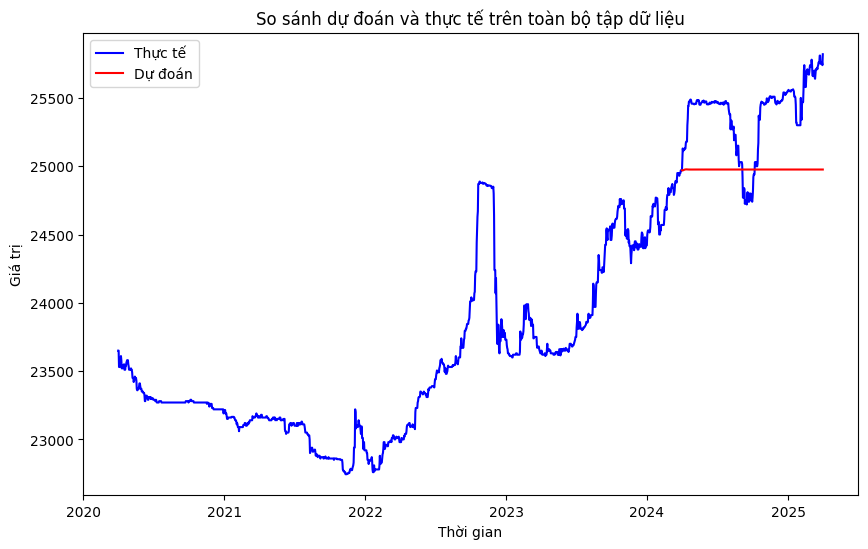

In [25]:
# Dự báo trên tập kiểm tra (test)
y_pred = result.forecast(steps=len(test))

# Dự báo trên toàn bộ tập dữ liệu (từ đầu đến hết test)
start = len(train)
end = len(train) + len(test) - 1

forecast_all = result.predict(start=start, end=end, typ='levels')  # 'levels' để giữ chuỗi gốc (không sai phân)

plt.figure(figsize=(10, 6))
plt.plot(y, label='Thực tế', color='blue')
plt.plot(forecast_all, label='Dự đoán', color='red')
plt.title('So sánh dự đoán và thực tế trên toàn bộ tập dữ liệu')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None
best_model = None

for p in range(10):
    for q in range(10):
        try:
            model = ARIMA(train, order=(p, 1, q))
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, 1, q)
                best_model = result
        except:
            continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
